# Notebook 1: Neural ODE 2D Classification

Este notebook implementa e treina Neural ODEs para classificação em dados 2D.

## Objetivos:
1. Implementar VectorField e NeuralODE com classificação
2. Treinar em dataset 2D sintético (moons, circles, spirals)
3. Visualizar trajetórias a partir de dados do dataset (x(0) → x(1))
4. Visualizar transformações a partir de z ~ N(0,I) (z(0) → x(1))
5. Visualizar vector fields
6. Analisar NFEs e comparar solvers


In [1]:
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('..')
import torch
import torch.optim as optim
from src.models.neural_ode import NeuralODE
from src.models.vector_field import VectorField
from src.utils.datasets import Synthetic2D, get_dataloader
from src.utils.training import train_neural_ode, count_nfe
from src.utils.visualization import Synthetic2DViz

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Directories for saving figures and checkpoints
FIGURES_DIR = '../results/figures'
CHECKPOINTS_DIR = '../results/checkpoints'
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

# Dataset and model names for file naming
DATASET_NAME = 'moons'
MODEL_NAME = 'neuralode'

Using device: cpu


## 1. Carregar Dataset


Figure saved to: ../results/figures/01_moons_neuralode.png


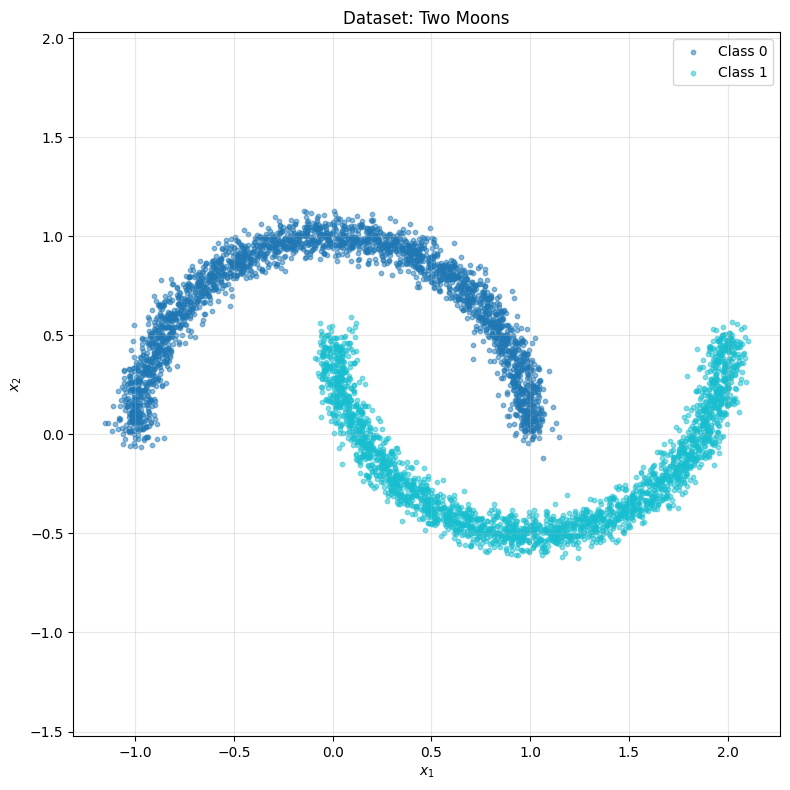

Dataset size: 5000
Number of classes: 2


In [2]:
# Criar dataset (moons, circles, ou spirals - todos têm 2 classes)
dataset = Synthetic2D(n_samples=5000, noise=0.05, dataset_type='moons')
dataloader = get_dataloader(dataset, batch_size=128, shuffle=True)

# Visualizar dados com cores por classe
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
Synthetic2DViz.plot_data_distribution(
    dataset.data,
    labels=dataset.labels,
    ax=ax,
    title="Dataset: Two Moons",
    save_path=os.path.join(FIGURES_DIR, f'01_{DATASET_NAME}_{MODEL_NAME}.png')
)
plt.tight_layout()
plt.show()

print(f"Dataset size: {len(dataset)}")
print(f"Number of classes: {len(torch.unique(dataset.labels))}")


## 2. Criar e Treinar Modelo


In [5]:
# Criar modelo com classificação (2 classes para moons/circles/spirals)
vf = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
model = NeuralODE(
    vf,
    solver='rk4',
    rtol=1e-5,
    atol=1e-5,
    num_classes=2  # 2 classes para datasets sintéticos
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Treinar para classificação
train_neural_ode(model, dataloader, optimizer, device, num_epochs=50)

# Salvar checkpoint
checkpoint_path = os.path.join(CHECKPOINTS_DIR, f'01__{DATASET_NAME}_{MODEL_NAME}.pt')
torch.save(model.state_dict(), checkpoint_path)
print(f"Checkpoint saved to: {checkpoint_path}")


Epoch 1/50: 100%|██████████| 40/40 [00:00<00:00, 51.40it/s]


Epoch 1, Loss: 0.509114, F1-score: 0.7487


Epoch 2/50: 100%|██████████| 40/40 [00:00<00:00, 50.31it/s]


Epoch 2, Loss: 0.275482, F1-score: 0.8742


Epoch 3/50: 100%|██████████| 40/40 [00:00<00:00, 51.34it/s]


Epoch 3, Loss: 0.217895, F1-score: 0.8960


Epoch 4/50: 100%|██████████| 40/40 [00:00<00:00, 51.83it/s]


Epoch 4, Loss: 0.196580, F1-score: 0.9068


Epoch 5/50: 100%|██████████| 40/40 [00:00<00:00, 48.40it/s]


Epoch 5, Loss: 0.166005, F1-score: 0.9196


Epoch 6/50: 100%|██████████| 40/40 [00:00<00:00, 43.41it/s]


Epoch 6, Loss: 0.137178, F1-score: 0.9416


Epoch 7/50: 100%|██████████| 40/40 [00:00<00:00, 50.03it/s]


Epoch 7, Loss: 0.106741, F1-score: 0.9566


Epoch 8/50: 100%|██████████| 40/40 [00:00<00:00, 49.95it/s]


Epoch 8, Loss: 0.075284, F1-score: 0.9736


Epoch 9/50: 100%|██████████| 40/40 [00:00<00:00, 51.24it/s]


Epoch 9, Loss: 0.044502, F1-score: 0.9912


Epoch 10/50: 100%|██████████| 40/40 [00:00<00:00, 51.55it/s]


Epoch 10, Loss: 0.029022, F1-score: 0.9980


Epoch 11/50: 100%|██████████| 40/40 [00:00<00:00, 51.26it/s]


Epoch 11, Loss: 0.018802, F1-score: 0.9996


Epoch 12/50: 100%|██████████| 40/40 [00:00<00:00, 49.42it/s]


Epoch 12, Loss: 0.012221, F1-score: 0.9996


Epoch 13/50: 100%|██████████| 40/40 [00:00<00:00, 41.85it/s]


Epoch 13, Loss: 0.009334, F1-score: 0.9998


Epoch 14/50: 100%|██████████| 40/40 [00:00<00:00, 53.82it/s]


Epoch 14, Loss: 0.007702, F1-score: 0.9994


Epoch 15/50: 100%|██████████| 40/40 [00:00<00:00, 55.10it/s]


Epoch 15, Loss: 0.005459, F1-score: 0.9998


Epoch 16/50: 100%|██████████| 40/40 [00:00<00:00, 54.08it/s]


Epoch 16, Loss: 0.004558, F1-score: 0.9998


Epoch 17/50: 100%|██████████| 40/40 [00:00<00:00, 56.24it/s]


Epoch 17, Loss: 0.003596, F1-score: 1.0000


Epoch 18/50: 100%|██████████| 40/40 [00:00<00:00, 51.60it/s]


Epoch 18, Loss: 0.003095, F1-score: 0.9998


Epoch 19/50: 100%|██████████| 40/40 [00:00<00:00, 50.04it/s]


Epoch 19, Loss: 0.002747, F1-score: 0.9998


Epoch 20/50: 100%|██████████| 40/40 [00:00<00:00, 50.12it/s]


Epoch 20, Loss: 0.002509, F1-score: 0.9998


Epoch 21/50: 100%|██████████| 40/40 [00:00<00:00, 51.54it/s]


Epoch 21, Loss: 0.001955, F1-score: 1.0000


Epoch 22/50: 100%|██████████| 40/40 [00:00<00:00, 42.13it/s]


Epoch 22, Loss: 0.002085, F1-score: 1.0000


Epoch 23/50: 100%|██████████| 40/40 [00:00<00:00, 57.68it/s]


Epoch 23, Loss: 0.001784, F1-score: 1.0000


Epoch 24/50: 100%|██████████| 40/40 [00:00<00:00, 53.53it/s]


Epoch 24, Loss: 0.001544, F1-score: 1.0000


Epoch 25/50: 100%|██████████| 40/40 [00:00<00:00, 52.29it/s]


Epoch 25, Loss: 0.001287, F1-score: 1.0000


Epoch 26/50: 100%|██████████| 40/40 [00:00<00:00, 51.18it/s]


Epoch 26, Loss: 0.001222, F1-score: 1.0000


Epoch 27/50: 100%|██████████| 40/40 [00:00<00:00, 53.11it/s]


Epoch 27, Loss: 0.001092, F1-score: 1.0000


Epoch 28/50: 100%|██████████| 40/40 [00:00<00:00, 52.56it/s]


Epoch 28, Loss: 0.000929, F1-score: 1.0000


Epoch 29/50: 100%|██████████| 40/40 [00:00<00:00, 55.09it/s]


Epoch 29, Loss: 0.000859, F1-score: 1.0000


Epoch 30/50: 100%|██████████| 40/40 [00:00<00:00, 54.84it/s]


Epoch 30, Loss: 0.000833, F1-score: 1.0000


Epoch 31/50: 100%|██████████| 40/40 [00:00<00:00, 51.40it/s]


Epoch 31, Loss: 0.000759, F1-score: 1.0000


Epoch 32/50: 100%|██████████| 40/40 [00:00<00:00, 52.73it/s]


Epoch 32, Loss: 0.000792, F1-score: 1.0000


Epoch 33/50: 100%|██████████| 40/40 [00:00<00:00, 52.45it/s]


Epoch 33, Loss: 0.000800, F1-score: 1.0000


Epoch 34/50: 100%|██████████| 40/40 [00:00<00:00, 54.10it/s]


Epoch 34, Loss: 0.000589, F1-score: 1.0000


Epoch 35/50: 100%|██████████| 40/40 [00:00<00:00, 51.98it/s]


Epoch 35, Loss: 0.000633, F1-score: 1.0000


Epoch 36/50: 100%|██████████| 40/40 [00:00<00:00, 51.27it/s]


Epoch 36, Loss: 0.000828, F1-score: 1.0000


Epoch 37/50: 100%|██████████| 40/40 [00:00<00:00, 55.94it/s]


Epoch 37, Loss: 0.000554, F1-score: 1.0000


Epoch 38/50: 100%|██████████| 40/40 [00:00<00:00, 46.05it/s]


Epoch 38, Loss: 0.000542, F1-score: 1.0000


Epoch 39/50: 100%|██████████| 40/40 [00:00<00:00, 41.55it/s]


Epoch 39, Loss: 0.000467, F1-score: 1.0000


Epoch 40/50: 100%|██████████| 40/40 [00:00<00:00, 53.07it/s]


Epoch 40, Loss: 0.000528, F1-score: 1.0000


Epoch 41/50: 100%|██████████| 40/40 [00:00<00:00, 51.67it/s]


Epoch 41, Loss: 0.000487, F1-score: 1.0000


Epoch 42/50: 100%|██████████| 40/40 [00:00<00:00, 54.84it/s]


Epoch 42, Loss: 0.000437, F1-score: 1.0000


Epoch 43/50: 100%|██████████| 40/40 [00:00<00:00, 54.61it/s]


Epoch 43, Loss: 0.000371, F1-score: 1.0000


Epoch 44/50: 100%|██████████| 40/40 [00:00<00:00, 53.99it/s]


Epoch 44, Loss: 0.000431, F1-score: 1.0000


Epoch 45/50: 100%|██████████| 40/40 [00:00<00:00, 53.77it/s]


Epoch 45, Loss: 0.000418, F1-score: 1.0000


Epoch 46/50: 100%|██████████| 40/40 [00:00<00:00, 54.11it/s]


Epoch 46, Loss: 0.000364, F1-score: 1.0000


Epoch 47/50: 100%|██████████| 40/40 [00:00<00:00, 53.76it/s]


Epoch 47, Loss: 0.000341, F1-score: 1.0000


Epoch 48/50: 100%|██████████| 40/40 [00:00<00:00, 53.30it/s]


Epoch 48, Loss: 0.000329, F1-score: 1.0000


Epoch 49/50: 100%|██████████| 40/40 [00:00<00:00, 48.97it/s]


Epoch 49, Loss: 0.000363, F1-score: 1.0000


Epoch 50/50: 100%|██████████| 40/40 [00:00<00:00, 53.24it/s]


Epoch 50, Loss: 0.000268, F1-score: 1.0000
Checkpoint saved to: ../results/checkpoints/01__moons_neuralode.pt


## 3. Visualizar Trajetórias


Figure saved to: ../results/figures/01_moons_neuralode_trajectories.png


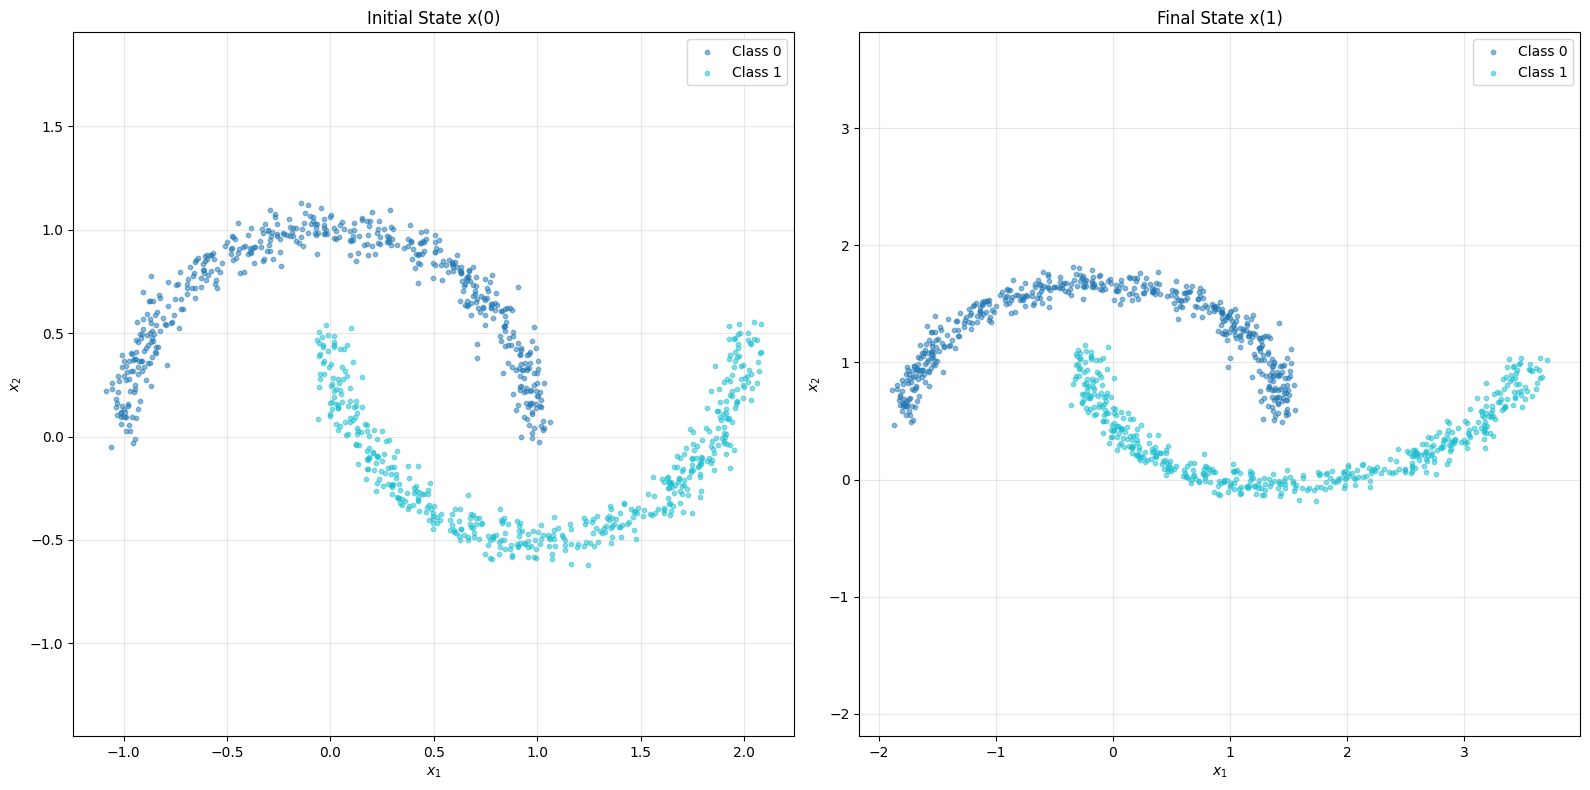

In [6]:
Synthetic2DViz.plot_trajectories(
    model,
    dataset,
    n_samples=1000,
    save_path=os.path.join(FIGURES_DIR, f'01_{DATASET_NAME}_{MODEL_NAME}_trajectories.png')
)
plt.tight_layout()
plt.show()


## 4. Visualizar Vector Field


Figure saved to: ../results/figures/01_moons_neuralode_vector_fields.png
Figure saved to: ../results/figures/01_moons_neuralode_vector_fields.png
Figure saved to: ../results/figures/01_moons_neuralode_vector_fields.png


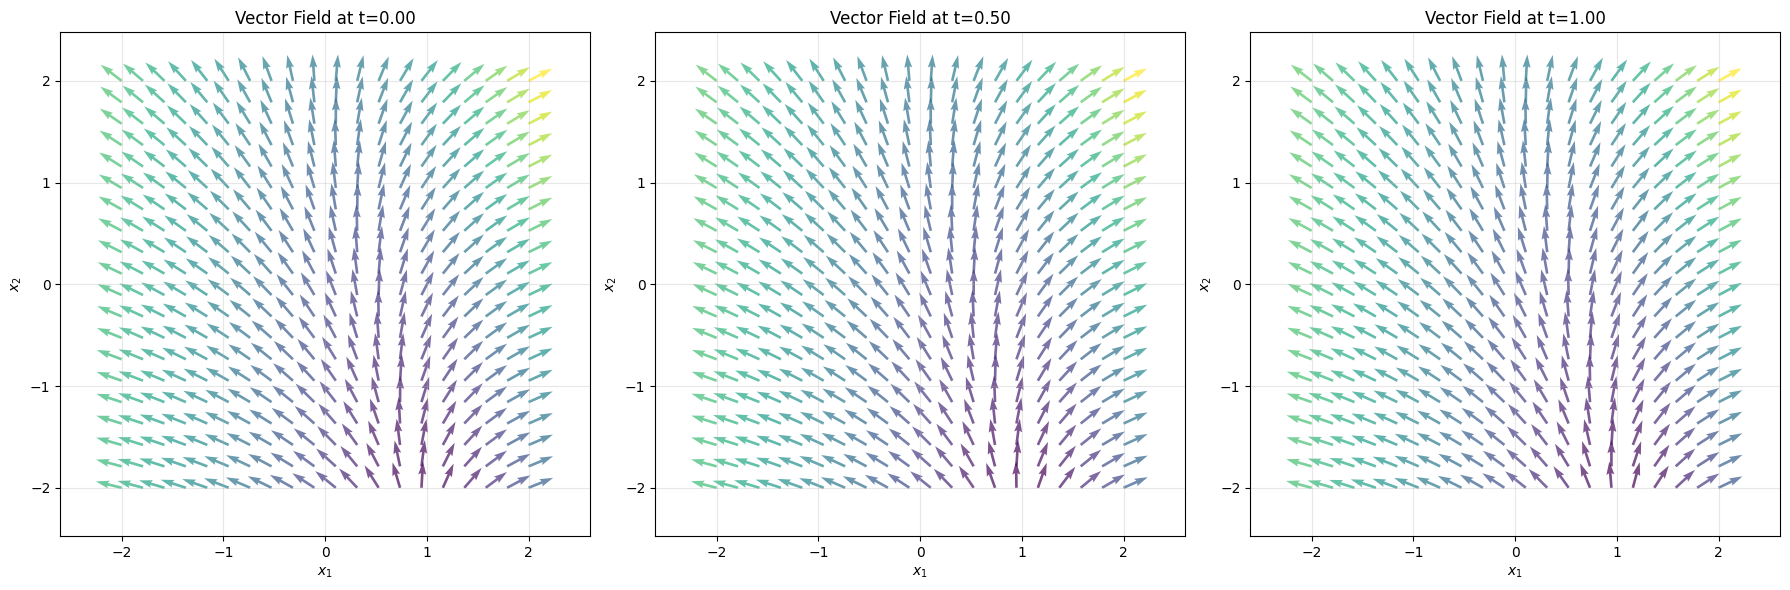

In [ ]:
# Plotar vector field em diferentes tempos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, t in enumerate([0.0, 0.5, 1.0]):
    Synthetic2DViz.plot_vector_field(
        model,
        xlim=(-2, 2),
        ylim=(-2, 2),
        n_grid=20,
        t=t,
        ax=axes[i],
        save_path=os.path.join(FIGURES_DIR, f'01_{DATASET_NAME}_{MODEL_NAME}_vector_fields.png')
    )
plt.tight_layout()
plt.show()


## 5. Visualizar Transformação


Figure saved to: ../results/figures/01_moons_neuralode_transformation.png


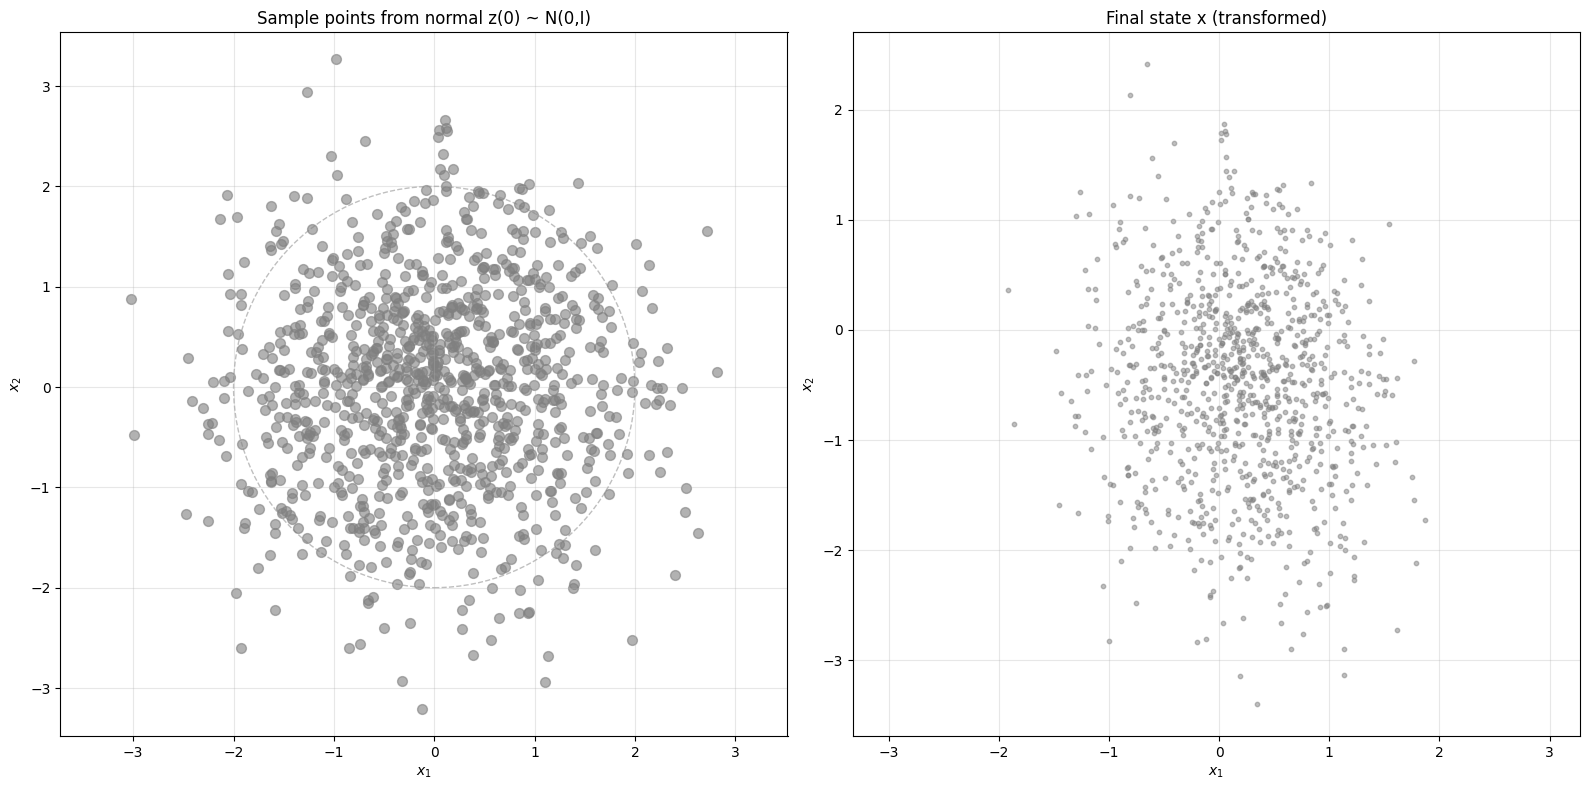

In [8]:
Synthetic2DViz.plot_transformation(
    model,
    n_samples=1000,
    n_points=100,
    save_path=os.path.join(FIGURES_DIR, f'01_{DATASET_NAME}_{MODEL_NAME}_transformation.png')
)
plt.tight_layout()
plt.show()


## 6. Analisar NFEs (Number of Function Evaluations)


In [ ]:
# Comparar diferentes solvers
solvers = ['euler', 'rk4', 'dopri5']
nfe_results = {}

# Usar amostras de N(0, I) para contagem de NFEs
sample_batch = torch.randn(10, 2).to(device)

print("=== Comparação de Solvers ===")
for solver in solvers:
    vf_test = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
    model_test = NeuralODE(
        vf_test,
        solver=solver,
        rtol=1e-3,
        atol=1e-4,
        num_classes=2
    ).to(device)
    model_test.vf.load_state_dict(model.vf.state_dict())
    if model.classifier is not None:
        model_test.classifier.load_state_dict(model.classifier.state_dict())

    nfe = count_nfe(model_test, sample_batch)
    nfe_results[solver] = nfe
    print(f"{solver}: {nfe} NFEs")

# Comparar diferentes tolerâncias
tolerances = [(1e-2, 1e-3), (1e-3, 1e-4), (1e-4, 1e-5)]
nfe_tol_results = {}

print("\n=== Comparação de Tolerâncias (dopri5) ===")
for rtol, atol in tolerances:
    vf_test = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
    model_test = NeuralODE(
        vf_test,
        solver='dopri5',
        rtol=rtol,
        atol=atol,
        num_classes=2
    ).to(device)
    model_test.vf.load_state_dict(model.vf.state_dict())
    if model.classifier is not None:
        model_test.classifier.load_state_dict(model.classifier.state_dict())

    nfe = count_nfe(model_test, sample_batch)
    nfe_tol_results[(rtol, atol)] = nfe
    print(f"rtol={rtol}, atol={atol}: {nfe} NFEs")
